In [202]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [203]:
class Material:
    def __init__(self, name, dir_name, tube_name, tube_directory, injected_mass = 1, mass_density = 1, diameter = 1):
        self.name = name
        self.dir_name = dir_name
        self.tube_name = tube_name
        self.tube_dir = tube_directory
        self.data_was_set = False
        self.M = injected_mass
        self.rho = mass_density
        self.r = diameter / 2 # radius (micro meters)
        self.set_data()

    @property
    def M(self):
        return self._M
    
    @M.setter
    def M(self, value):
        self._M = value

    def set_data(self):
        file_names = [os.path.join(self.tube_dir, self.dir_name, file_name) for file_name in os.listdir(os.path.join(self.tube_dir, self.dir_name)) if file_name.endswith('.CSV')]
        column_names = ['TIME', 'CH1', 'CH2']
        runs = []
        for i, run in enumerate(file_names):
            runs.append(pd.read_csv(file_names[i], engine='python', usecols=column_names, on_bad_lines='skip'))
        self.num_runs = len(runs)
        self.times = [run['TIME'] for run in runs]
        self.CH1 = [run['CH1'] for run in runs]
        self.data_was_set = True

    @property
    def Qs(self):
        e_charge = 1.602176634e-19 # elementary charge in Coulombs

        integration_results = []
        for idx, (time_val, ch1_series) in enumerate(zip(self.times, self.CH1)):
            integral =  - np.trapezoid(ch1_series, time_val) / 5 / 1000000
            integration_results.append(integral) # in Coulombs
        return np.array(integration_results) / e_charge # in e
    
    # Q is the charge in eV
    # rho is the mass density in g/cm^3
    # r is the radius in micro meters
    # M is the injected mass in grams
    # returns the charge per surface area in eV/microm^2
    def charge_per_surface_area(self, Q):
        rho = self.rho * 10000 # convert to g/microm^3
        sigma = (Q * rho * self.r) / (3 * self.M)
        return sigma
    
    def plot_ch1(self, ax):
        ax.grid()
        ax.set_title(f'Oscilloscope data of {self.name} in {self.tube_name}')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Voltage (V)')
        if self.data_was_set:
            for idx, (time_val, ch1_series) in enumerate(zip(self.times, self.CH1)):
                ax.plot(time_val, ch1_series, label=f'{self.tube_name} Run {idx+1}')

In [204]:
#measure_scooped_mass: mass of the material scooped in the measure cup (g)
#num_measure_scoops: number of scoops of material in the measure cup (unitless)
#h_measure: height of the measure cup (cm)
#d_measure: diameter of the measure cup (cm)
#h: height of the actual cup (must be in the same units as h_measure)
#d: diameter of the actual cup (must be in the same units as d_measure)
#returns the mass of the material in the actual cup (g)
def mass_calc(measure_scooped_mass, num_measure_scoops, h_measure, d_measure, h, d):
    V_measure = np.pi * (d_measure / 2) ** 2 * h_measure #(cm^3)
    rho = measure_scooped_mass / (num_measure_scoops * V_measure) #(g/cm^3)
    V = np.pi * (d / 2) ** 2 * h #(cm^3)
    M = rho * V
    return M #(g)

In [205]:
glass_tube_dir = "Glass Tube"
al_oxide_tube_dir = "Al Oxide Tube"

In [206]:
slg = Material('SLG', 'SLG', 'Glass Tube', glass_tube_dir, diameter = 5.6, mass_density=0.563)
slg.M = mass_calc(1.72, 3, 0.9, 1.2, 0.0001, 0.0001)
slg.M

4.4238683127572013e-13

[6.82145012e+10 5.90846215e+10 5.19755926e+10 7.18092110e+10]
1.5419650049617122e+23


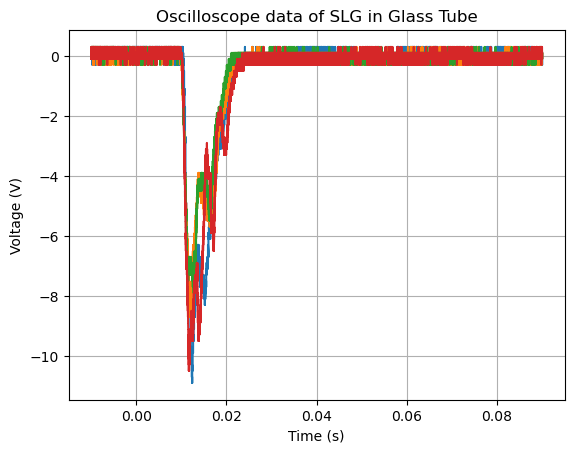

In [207]:
fig, ax = plt.subplots()
slg.plot_ch1(ax)
print(slg.Qs)
print(slg.Qs[0] / slg.M)

In [208]:
print(slg.charge_per_surface_area(slg.Qs))


[8.10251211e+26 7.01806585e+26 6.17365605e+26 8.52949140e+26]
